<a href="https://colab.research.google.com/github/sabeesh90/Multimodal-Architectures-Deep_Learning/blob/main/Thesis_Sloan_Custom_models_2_with_EVA_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <p style = "text-align:center"><font color  = 'blue'> Thesis Dissertation - Masters

## **Data set preparation**

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from skimage import io
import pathlib
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
!pip install -q -U keras-tuner
import kerastuner as kt
%load_ext tensorboard
warnings.filterwarnings("ignore")


     |████████████████████████████████| 96 kB 4.0 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


##### <font color = "blue"> Custom Deep Learning model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


#### **Tensorflow conventional loading dataset from directory**

In [ ]:
dataset_path = 'Images'
img_width = 512
img_height = 512
channels = 3
num_classes = 3
batch_size = 32

def generate_data(batch_size = batch_size, img_width = img_width, img_height = img_height):
    channels = 3
    num_classes = 3
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'training',seed = 123, image_size = (img_width, img_height), 
                                                                  batch_size = batch_size, label_mode = 'categorical')
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'validation',seed = 123, image_size = (img_width, img_height),
                                                                batch_size = batch_size, label_mode = 'categorical')
    class_names = train_ds.class_names
    print(class_names)
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    print(f'The number of batches in training data set is {len(train_ds)} and in evaluation set is {len(val_ds)}')

    return (train_ds, val_ds)
    
train_ds, val_ds = generate_data()

Found 1000 files belonging to 3 classes.
Using 800 files for training.
Found 1000 files belonging to 3 classes.
Using 200 files for validation.
['GALAXY', 'QSO', 'STAR']
The number of batches in training data set is 25 and in evaluation set is 7


#### **Image augmentation code and testing using conventional tensorflow libraries**


##### Non rigid transformation  - Image augmentation

In [ ]:
data_augmentation  = tf.keras.Sequential(
    [layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), # these are rigid transformation techniques  - flipping, rotation 
     layers.experimental.preprocessing.RandomRotation(0.2)])
# This layer can be added directly to the model bu is done here for testing purposed

In [ ]:
def generate_image(c = 0, n = 0, aug = False):
    dataset_path = 'Images'
    ast_class_path  = os.path.join(dataset_path, classes[c], '*')
    print(ast_class_path)
    # n = np.random.randint(0, len(ast_class_path))
    ast_image_path = glob.glob(ast_class_path)
    # print(ast_image_path[n])
    image = io.imread(ast_image_path[n])
        
    if aug == False:
        print(image.shape)
        plt.imshow(image)
        plt.show()
    else:
        plt.figure(figsize = (15,5))  
        print(image.shape)    
        image_expanded = tf.expand_dims(image,0)
        print(image.shape)  
        augmented_image = data_augmentation(image_expanded)
        plt.figure(figsize = (15,5))
        plt.subplot(1,2,1)
        plt.title('original_image')
        plt.imshow(image)
        plt.subplot(1,2,2)
        plt.title('augmented_image')
        plt.imshow(augmented_image[0])

In [ ]:
# generate_image(0,4, aug = True)

#### **Defining functions for code shortening**

In [ ]:
def generate_graph(model_training):
    plt.figure(figsize= (15,5))
    plt.subplot(1,2,1)
    plt.plot(model_training.history.history['accuracy'])
    plt.plot(model_training.history.history['val_accuracy'])
    plt.title('Training vs TestAccuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.subplot(1,2,2)
    plt.plot(model_training.history.history['loss'])
    plt.plot(model_training.history.history['val_loss'])
    plt.title('Training loss vs Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.show()

# Defining callbacks for the models
filepath = './custom_dnn'
reduced_lr = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.2, patience = 5, min_lr = 0.001) # This conssists of the default values
model_checkpoint  = tf.keras.callbacks.ModelCheckpoint(filepath =filepath,save_best_only=True, verbose = 1)
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10,verbose= 1, monitor = 'val_accuracy')
tensorboard_callback = tf.keras.callbacks.TensorBoard(histogram_freq=1)
callbacks = [reduced_lr, model_checkpoint, early_stopping ,tensorboard_callback]

def run_model(model_training, epochs = 50):
    optimizer = optimizers.Adam(learning_rate = 1e-3)
    model_training.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    print(model_training.summary())
    class_weight = {0:1.13, 1:8.03, 2:1} # this is done by dividing the total number of highest occurence of classes by that particul count of class
    model_training.fit(train_ds,validation_data=val_ds,epochs = epochs, verbose = 1, workers = 3, class_weight  = class_weight)
    generate_graph(model_training)

# optimizer = optimizers.Adam(lr = 1e-3)
# model4.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
# model4.summary()
# model4.fit(train_ds,validation_data=val_ds,epochs = 10, verbose = 1, workers = 3)

## **Baseline model - 128C - 256-512D - Adam - Accuracy/0.4D**

In [ ]:
def baseline_model(aug = False):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    if aug == True:
        model.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
    model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())    
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
      
    model.add(Flatten())

    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.4))

    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.4))

    model.add(Dense(num_classes, activation = 'softmax'))
    return model
    
model4 = baseline_model()
model4_aug = baseline_model(aug = True)

In [ ]:
optimizer = optimizers.Adam(lr = 1e-4)
model4.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
model4_aug.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
model4.summary()
model4.fit(train_ds,validation_data=val_ds,epochs = 50, verbose = 1, workers = 3)
model4_aug.fit(train_ds,validation_data=val_ds,epochs = 50, verbose = 1, workers = 3)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization_14 (Batc (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 256, 256, 64)      18496     
_________________________________________________________________
batch_normalization_15 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 128, 128, 64)     

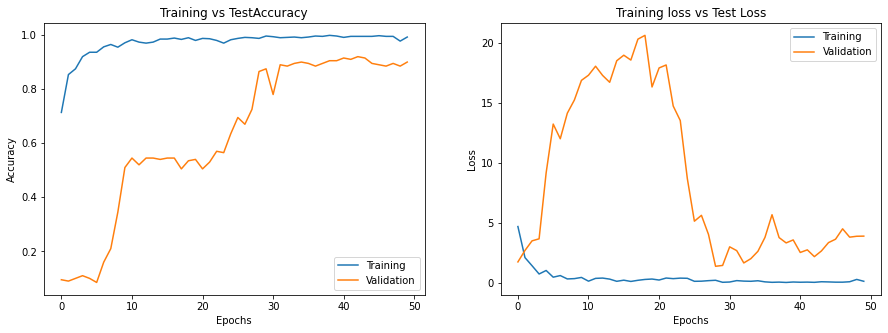

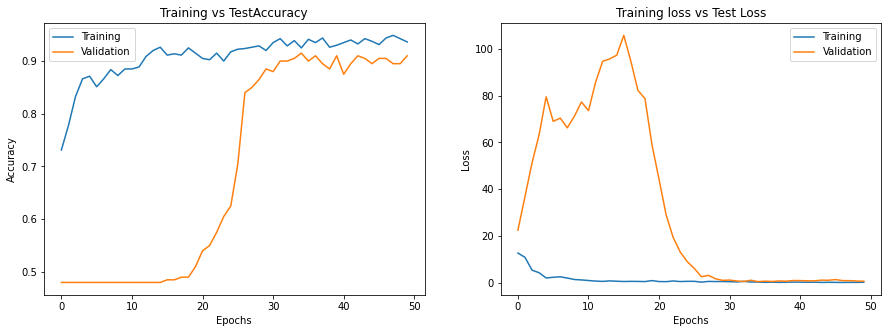

In [ ]:
generate_graph(model4)
generate_graph(model4_aug)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization_11 (Batc (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 256, 256, 64)      18496     
_________________________________________________________________
batch_normalization_12 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 64)     

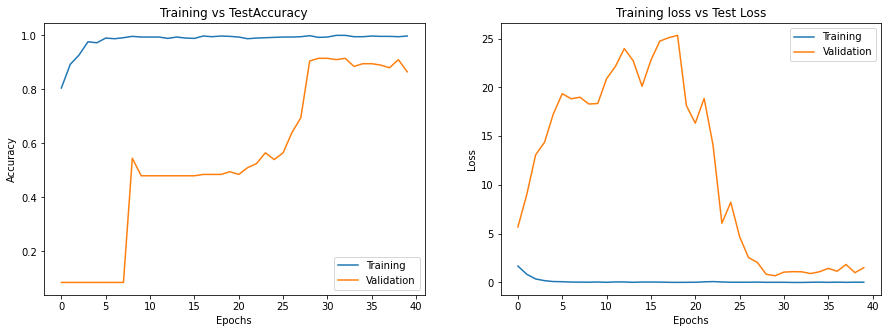

In [ ]:
def baseline_model():
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))


    model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())    
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Conv2D(256, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
      
    model.add(Flatten())

    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation = 'softmax'))
    return model
    
model5 = baseline_model()
optimizer = optimizers.Adam(lr = 1e-4)
model5.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
model5.summary()
model5.fit(train_ds,validation_data=val_ds,epochs = 40, verbose = 1, workers = 3)
generate_graph(model5)

Plotting the 

#### Baseline model - 256C - 512D - SGD - Accuracy - 0.75 droopout

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
from keras.regularizers import l1_l2

model_name_custom = 'sloan_custom' +'/'    
if not os.path.exists(model_name_custom):
    os.mkdir(model_name_custom)        
filepath_custom = model_name_custom + 'model-{epoch:05d}-{loss:.2f}-{accuracy:.4f}-{val_loss:.2f}-{val_accuracy:.4f}.h5'
model_checkpoint_callback_custom = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath_custom,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True,
    verbose = 1
    )
# import datetime
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [model_checkpoint_callback_custom, reduce_lr]
# callbacks = [reduce_lr]
class_weight = {0:1.13, 1:8.03, 2:1}

In [ ]:
def baseline_model(aug = False):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    if aug == True:
        model.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
        # model.add(layers.experimental.preprocessing.RandomRotation(0.2))
#--------------------------------------------------------------------------------------------------#      
    model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
#----------------------------------------------------------------------------------------------------#    
    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(256, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))    
#--------------------------------------------------------------------------------------------------#    
    model.add(Conv2D(512, kernel_size = (3,3), padding = 'same', activation  = 'relu',kernel_regularizer=l1_l2(0.03))) # for normal its 0.08 in both these layers.
    # model.add(Conv2D(512, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Conv2D(512, kernel_size = (3,3), padding = 'same', activation  = 'relu',kernel_regularizer=l1_l2(0.03)))
    # model.add(Conv2D(512, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
#--------------------------------------------------------------------------------------------------#    
    model.add(GlobalAveragePooling2D())    
#--------------------------------------------------------------------------------------------------#
    model.add(Dense(num_classes, activation = 'softmax'))
    return model
#--------------------------------------------------------------------------------------------------#

model5 = baseline_model()
model5_aug = baseline_model(aug=True)
optimizer = optimizers.Adam(lr = 1e-4)
model5.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
model5_aug.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
model5.summary()
model5_aug.summary()
    

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_16 (Rescaling)     (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization_96 (Batc (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 256, 256, 64)      18496     
_________________________________________________________________
batch_normalization_97 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 128, 128, 64)    

##### Normal model 7 GAP

In [ ]:
model5.fit(train_ds,validation_data=val_ds,epochs = 90, verbose = 1, workers = 3, callbacks = callbacks)

Epoch 1/90
25/25 [==============================] - 7s 218ms/step - loss: 3477.2993 - accuracy: 0.6862 - val_loss: 3133.3303 - val_accuracy: 0.4800

Epoch 00001: val_accuracy did not improve from 0.94000
Epoch 2/90
25/25 [==============================] - 5s 207ms/step - loss: 2835.7654 - accuracy: 0.8650 - val_loss: 2525.7668 - val_accuracy: 0.4800

Epoch 00002: val_accuracy did not improve from 0.94000
Epoch 3/90
25/25 [==============================] - 5s 208ms/step - loss: 2259.4893 - accuracy: 0.8938 - val_loss: 1983.7577 - val_accuracy: 0.4800

Epoch 00003: val_accuracy did not improve from 0.94000
Epoch 4/90
25/25 [==============================] - 5s 208ms/step - loss: 1749.2937 - accuracy: 0.9087 - val_loss: 1508.1071 - val_accuracy: 0.4800

Epoch 00004: val_accuracy did not improve from 0.94000
Epoch 5/90
25/25 [==============================] - 5s 208ms/step - loss: 1305.4128 - accuracy: 0.9187 - val_loss: 1098.7250 - val_accuracy: 0.4900

Epoch 00005: val_accuracy did not i

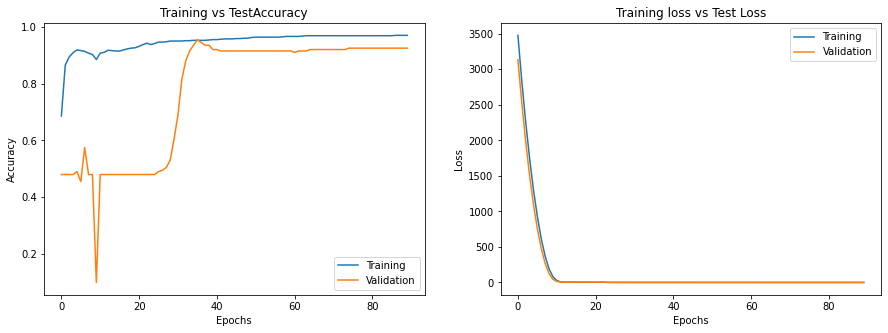

In [ ]:
generate_graph(model5)

##### Augmented model  7 GAP

In [ ]:
model5_aug.fit(train_ds,validation_data=val_ds,epochs = 100, verbose = 1, workers = 3, callbacks = callbacks)
# model5_aug.fit(train_ds,validation_data=val_ds,epochs = 45, verbose = 1, workers = 3)

Epoch 1/100
25/25 [==============================] - 7s 225ms/step - loss: 445.7658 - accuracy: 0.8062 - val_loss: 405.3736 - val_accuracy: 0.4800

Epoch 00001: val_accuracy did not improve from 0.94500
Epoch 2/100
25/25 [==============================] - 5s 214ms/step - loss: 368.8601 - accuracy: 0.8612 - val_loss: 331.9802 - val_accuracy: 0.4800

Epoch 00002: val_accuracy did not improve from 0.94500
Epoch 3/100
25/25 [==============================] - 5s 214ms/step - loss: 299.0828 - accuracy: 0.8838 - val_loss: 266.2881 - val_accuracy: 0.4800

Epoch 00003: val_accuracy did not improve from 0.94500
Epoch 4/100
25/25 [==============================] - 5s 214ms/step - loss: 237.0907 - accuracy: 0.8963 - val_loss: 208.3892 - val_accuracy: 0.4800

Epoch 00004: val_accuracy did not improve from 0.94500
Epoch 5/100
25/25 [==============================] - 5s 213ms/step - loss: 182.9848 - accuracy: 0.8913 - val_loss: 158.4011 - val_accuracy: 0.4800

Epoch 00005: val_accuracy did not improv

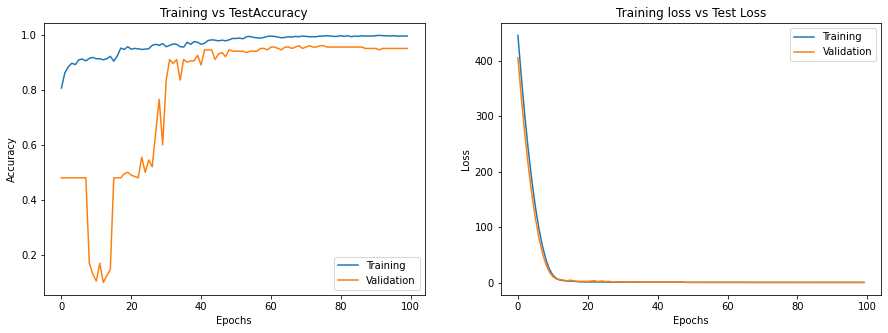

In [ ]:
generate_graph(model5_aug)
# generate_graph(model5_aug)

In [ ]:
class Metrics:
    # from sklearn
    def __init__(self, model, val_ds):
        self.val_ds = val_ds
        self.model = model
        self.prediction_classes = np.array([])
        self.true_classes = np.array([])
        
    def calculate_scores(self):     
        print('calculating score.....')   
        
        for x, y in self.val_ds:
            self.prediction_classes = np.concatenate([self.prediction_classes,np.argmax(self.model.predict(x), axis = -1)])
            self.true_classes = np.concatenate([self.true_classes, np.argmax(y.numpy(), axis=-1)])
        
        class_report = classification_report(self.true_classes, self.prediction_classes,digits=4)
        conf_matrix = confusion_matrix(self.true_classes, self.prediction_classes)
        print(conf_matrix)
        print('------------------------------------')
        print(class_report)

In [ ]:
from tensorflow.keras.models import Sequential, Model, load_model
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
custom_model  = load_model('./sloan_custom/model-00036-0.70-0.9525-0.81-0.9550.h5')
custom_model_aug = load_model('./sloan_custom/model-00069-0.17-0.9925-0.30-0.9600.h5')

In [ ]:
metrics = Metrics(custom_model, val_ds)
metrics_aug = Metrics(custom_model_aug, val_ds)

In [ ]:
metrics.calculate_scores()

calculating score.....
[[96  0  0]
 [ 0  8  9]
 [ 0  0 87]]
------------------------------------
              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000        96
         1.0     1.0000    0.4706    0.6400        17
         2.0     0.9062    1.0000    0.9508        87

    accuracy                         0.9550       200
   macro avg     0.9688    0.8235    0.8636       200
weighted avg     0.9592    0.9550    0.9480       200



In [ ]:
metrics_aug.calculate_scores()

calculating score.....
[[95  0  1]
 [ 0 11  6]
 [ 0  1 86]]
------------------------------------
              precision    recall  f1-score   support

         0.0     1.0000    0.9896    0.9948        96
         1.0     0.9167    0.6471    0.7586        17
         2.0     0.9247    0.9885    0.9556        87

    accuracy                         0.9600       200
   macro avg     0.9471    0.8750    0.9030       200
weighted avg     0.9602    0.9600    0.9576       200



##### repear

In [ ]:
model5.fit(train_ds,validation_data=val_ds,epochs = 100, verbose = 1, workers = 3, callbacks = callbacks, class_weight = class_weight)

Epoch 1/100
25/25 [==============================] - 7s 220ms/step - loss: 1319.9967 - accuracy: 0.5038 - val_loss: 1199.5813 - val_accuracy: 0.4350

Epoch 00001: val_accuracy did not improve from 0.93000
Epoch 2/100
25/25 [==============================] - 5s 210ms/step - loss: 1094.7700 - accuracy: 0.7163 - val_loss: 984.8144 - val_accuracy: 0.4350

Epoch 00002: val_accuracy did not improve from 0.93000
Epoch 3/100
25/25 [==============================] - 5s 211ms/step - loss: 889.7939 - accuracy: 0.7513 - val_loss: 790.9936 - val_accuracy: 0.4350

Epoch 00003: val_accuracy did not improve from 0.93000
Epoch 4/100
25/25 [==============================] - 5s 210ms/step - loss: 706.4568 - accuracy: 0.8000 - val_loss: 619.3366 - val_accuracy: 0.4350

Epoch 00004: val_accuracy did not improve from 0.93000
Epoch 5/100
25/25 [==============================] - 5s 211ms/step - loss: 545.5935 - accuracy: 0.7975 - val_loss: 470.4429 - val_accuracy: 0.4350

Epoch 00005: val_accuracy did not imp

In [ ]:
model5_aug.fit(train_ds,validation_data=val_ds,epochs = 90, verbose = 1, workers = 3, callbacks = callbacks, class_weight  = class_weight)

In [ ]:
custom_model  = load_model('./sloan_custom/model-00035-2.36-0.9700-2.33-0.9500.h5')
metrics = Metrics(custom_model, val_ds)
metrics.calculate_scores()
metrics.

calculating score.....
[[94  0  2]
 [ 0 11  6]
 [ 0  2 85]]
------------------------------------
              precision    recall  f1-score   support

         0.0     1.0000    0.9792    0.9895        96
         1.0     0.8462    0.6471    0.7333        17
         2.0     0.9140    0.9770    0.9444        87

    accuracy                         0.9500       200
   macro avg     0.9200    0.8677    0.8891       200
weighted avg     0.9495    0.9500    0.9481       200



#### Keras tuner - 256C - 512D - Adam - Accuracy without augmentation

In [ ]:
def model_builder_new1(hp):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())    
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
      
    model.add(Flatten())

    dense_units1 = hp.Int('dense_ratio1', min_value=256, max_value=384, step=128)
    model.add(Dense(dense_units1))
    dropout1_units = hp.Float('dropout_ratio1', min_value=0.25, max_value=0.75, step=0.25)
    model.add(Dropout(dropout1_units))

    dense_units2 = hp.Int('dense_ratio2', min_value=384, max_value=512, step=128)
    model.add(Dense(dense_units2))
    dropout2_units = hp.Float('dropout_ratio2', min_value=0.25, max_value=0.75, step=0.25)
    model.add(Dropout(dropout2_units))

    model.add(Dense(num_classes, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(learning_rate = 1e-4), metrics = ['accuracy'])
    return model

In [ ]:
tuner = kt.Hyperband(hypermodel=model_builder_new1, objective='val_accuracy', max_epochs = 40, directory='./test' , project_name = 'custom_tuner')
early_stopback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(train_ds,validation_data=val_ds, epochs = 40, verbose = 1, workers = 3, callbacks = [early_stopback])

Trial 32 Complete [00h 00m 17s]
val_accuracy: 0.47999998927116394

Best val_accuracy So Far: 0.5400000214576721
Total elapsed time: 00h 25m 13s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hyperparamters = tuner.get_best_hyperparameters()[0]
dense_ratio1= best_hyperparamters.get('dense_ratio1')
dropout_ratio1= best_hyperparamters.get('dropout_ratio1')
dense_ratio2= best_hyperparamters.get('dense_ratio2')
dropout_ratio2= best_hyperparamters.get('dropout_ratio2')

print(f'The best hyperparameter for denseunit1 is {dense_ratio1} and dropout first  {dropout_ratio1} and denseunit2 is {dense_ratio2} and dropout second is {dropout_ratio2}' )

The best hyperparameter for denseunit1 is 384 and dropout first  0.75 and denseunit2 is 512 and dropout second is 0.5


In [ ]:
#### GEtting the best model from the  hyperparmaters
tuner_model = tuner.hypermodel.build(best_hyperparamters)
tuner_model_history  = tuner_model.fit(train_ds,validation_data=val_ds, epochs = 40, verbose = 1, workers = 3,)

Epoch 1/40
25/25 [==============================] - 4s 145ms/step - loss: 19.5149 - accuracy: 0.6690 - val_loss: 10.2074 - val_accuracy: 0.4800
Epoch 2/40
25/25 [==============================] - 3s 138ms/step - loss: 15.9308 - accuracy: 0.8499 - val_loss: 30.0946 - val_accuracy: 0.0850
Epoch 3/40
25/25 [==============================] - 3s 138ms/step - loss: 11.8133 - accuracy: 0.9027 - val_loss: 31.3282 - val_accuracy: 0.0850
Epoch 4/40
25/25 [==============================] - 3s 138ms/step - loss: 7.4646 - accuracy: 0.9236 - val_loss: 43.5072 - val_accuracy: 0.5550
Epoch 5/40
25/25 [==============================] - 3s 138ms/step - loss: 10.3309 - accuracy: 0.9453 - val_loss: 93.1561 - val_accuracy: 0.0850
Epoch 6/40
25/25 [==============================] - 3s 138ms/step - loss: 8.9433 - accuracy: 0.9349 - val_loss: 87.4288 - val_accuracy: 0.5400
Epoch 7/40
25/25 [==============================] - 3s 138ms/step - loss: 4.7234 - accuracy: 0.9393 - val_loss: 127.0124 - val_accuracy: 0

Text(0.5, 1.0, 'Epochs Vvs validation accuracy')

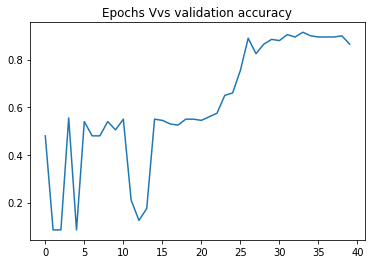

In [ ]:
plt.plot(tuner_model.history.history['val_accuracy'])
plt.title('Epochs vs validation accuracy')

In [ ]:
accuracy_list = tuner_model.history.history['val_accuracy']
best_epoch  = accuracy_list.index(max(accuracy_list))+1
print(f'The best epoch is epoch number {best_epoch}')

The best epoch is epoch number 34


In [ ]:
#### Re training the model
tuner_model = tuner.hypermodel.build(best_hyperparamters)
tuner_model_final  = tuner_model.fit(train_ds,validation_data=val_ds, epochs = best_epoch, verbose = 1, workers = 3)

Epoch 1/34
25/25 [==============================] - 4s 144ms/step - loss: 24.2500 - accuracy: 0.6343 - val_loss: 13.9765 - val_accuracy: 0.4800
Epoch 2/34
25/25 [==============================] - 3s 138ms/step - loss: 21.1321 - accuracy: 0.8419 - val_loss: 22.9163 - val_accuracy: 0.4800
Epoch 3/34
25/25 [==============================] - 3s 137ms/step - loss: 15.7489 - accuracy: 0.8751 - val_loss: 41.8009 - val_accuracy: 0.4800
Epoch 4/34
25/25 [==============================] - 3s 137ms/step - loss: 6.4892 - accuracy: 0.9267 - val_loss: 81.8091 - val_accuracy: 0.4800
Epoch 5/34
25/25 [==============================] - 3s 137ms/step - loss: 13.8412 - accuracy: 0.8956 - val_loss: 113.9456 - val_accuracy: 0.4800
Epoch 6/34
25/25 [==============================] - 3s 137ms/step - loss: 13.8735 - accuracy: 0.9306 - val_loss: 108.5651 - val_accuracy: 0.4800
Epoch 7/34
25/25 [==============================] - 3s 137ms/step - loss: 8.1204 - accuracy: 0.9341 - val_loss: 124.0526 - val_accuracy

Text(0.5, 1.0, 'Tuner modelepochs vs validation accuracy')

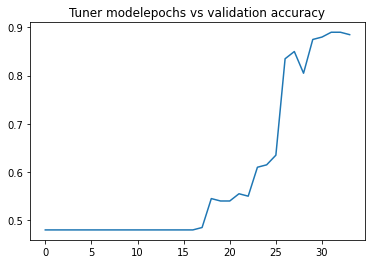

In [ ]:
plt.plot(tuner_model_final.history['val_accuracy'])
plt.title('Tuner modelepochs vs validation accuracy')